# Mixup: BEYOND EMPIRICAL RISK MINIMIZATION
Paper: [https://arxiv.org/pdf/1710.09412.pdf](https://arxiv.org/pdf/1710.09412.pdf)

## Import modules

In [1]:
import os 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from PIL import Image
from netcal.metrics import MCE, ECE
from sklearn.metrics import accuracy_score

import tensorflow as tf 
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

## Load data

In [2]:
BATCH_SIZE = 32

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Scale data 
X_train, X_test = X_train/255, X_test/255

# Add channel dim 
X_train, X_test = X_train[...,np.newaxis], X_test[...,np.newaxis]

# One-hot encode target 
y_train = tf.one_hot(y_train, 10).numpy()
y_test = tf.one_hot(y_test, 10).numpy()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (48000, 28, 28, 1)
y_train shape: (48000, 10)
X_val shape: (12000, 28, 28, 1)
y_val shape: (12000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [5]:
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

## Model 

In [6]:
def getModel(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(8,4,strides=(2, 2),activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(16,2,strides=(2, 2),activation='relu')(x)
    x = tf.keras.layers.Conv2D(32,2,strides=(1, 1),activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    yh = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs, yh)
    return model 

## Mixup 

$ \tilde{x} = \lambda x_i + (1-\lambda ) x_j $ <br>
$ \tilde{y} = \lambda y_i + (1-\lambda ) y_j$

Use a beta distruibtuion to sample $\lambda$ <br>
Beta: $f(x;a,b)=x^{\alpha - 1} (1-x)^{\beta -1}$ 

In [7]:
def betaPDF(x,alpha,beta):
    return x**(alpha-1)*(1-x)**(beta-1)

/Users/rick/opt/anaconda3/envs/tfp_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


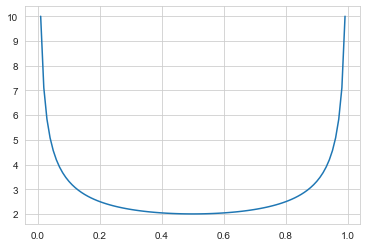

In [8]:
ALPHA = 0.5
BETA = 0.5

x = np.linspace(0,1,100)
y = betaPDF(x,ALPHA,BETA)
plt.plot(x,y)

## Train base model 

In [9]:
model = getModel((28,28,1))
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 8)         136       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          528       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          2080      
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                8010      
Total params: 10,754
Trainable params: 10,754
Non-trainable params: 0
_________________________________________________________

In [10]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = keras.losses.CategoricalCrossentropy()
val_acc_metric = keras.metrics.Accuracy()

EPOCHS = 15
for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            yh = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, yh)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        yh = model(x_batch_val, training=False)
        val_acc_metric.update_state(np.argmax(y_batch_val,axis=-1), np.argmax(yh,axis=-1))
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))


Start of epoch 0
Validation acc: 0.8928

Start of epoch 1
Validation acc: 0.9111

Start of epoch 2
Validation acc: 0.9227

Start of epoch 3
Validation acc: 0.9340

Start of epoch 4
Validation acc: 0.9432

Start of epoch 5
Validation acc: 0.9515

Start of epoch 6
Validation acc: 0.9557

Start of epoch 7
Validation acc: 0.9597

Start of epoch 8
Validation acc: 0.9632

Start of epoch 9
Validation acc: 0.9667

Start of epoch 10
Validation acc: 0.9676

Start of epoch 11
Validation acc: 0.9702

Start of epoch 12
Validation acc: 0.9721

Start of epoch 13
Validation acc: 0.9735

Start of epoch 14
Validation acc: 0.9745


## Train model with mixup

In [11]:
model_mixup = getModel((28,28,1))
print(model_mixup.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 8)         136       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 16)          528       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          2080      
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
Total params: 10,754
Trainable params: 10,754
Non-trainable params: 0
_______________________________________________________

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = keras.losses.CategoricalCrossentropy()
val_acc_metric = keras.metrics.Accuracy()

EPOCHS = 15
for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        x_batch_train, y_batch_train = x_batch_train.numpy(), y_batch_train.numpy()
        beta_values = np.random.beta(.5,.5,1)
        x_batch_train_s, y_batch_train_s = shuffle(x_batch_train, y_batch_train)
        x_batch_train = x_batch_train*beta_values+(1-beta_values)*x_batch_train_s
        y_batch_train = y_batch_train*beta_values + (1-beta_values)*y_batch_train_s
        
        with tf.GradientTape() as tape:
            yh = model_mixup(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, yh)

        grads = tape.gradient(loss_value, model_mixup.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_mixup.trainable_weights))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        yh = model_mixup(x_batch_val, training=False)
        val_acc_metric.update_state(np.argmax(y_batch_val,axis=-1), np.argmax(yh,axis=-1))
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))


Start of epoch 0
Validation acc: 0.8721

Start of epoch 1
Validation acc: 0.8950

Start of epoch 2
Validation acc: 0.9086

Start of epoch 3
Validation acc: 0.9208

Start of epoch 4
Validation acc: 0.9283

Start of epoch 5
Validation acc: 0.9353

Start of epoch 6
Validation acc: 0.9428

Start of epoch 7
Validation acc: 0.9482

Start of epoch 8
Validation acc: 0.9513

Start of epoch 9
Validation acc: 0.9530

Start of epoch 10
Validation acc: 0.9573

Start of epoch 11
Validation acc: 0.9588

Start of epoch 12
Validation acc: 0.9598

Start of epoch 13
Validation acc: 0.9613

Start of epoch 14
Validation acc: 0.9603


## Compare model on OOD

In [13]:
def NLL(y_pred,y_true):
    nll = -1*tf.math.reduce_sum(y_true*tf.math.log(y_pred),axis=-1)
    return tf.math.reduce_mean(nll)

def brier_score(labels, probs=None, logits=None):
    """Compute elementwise Brier score.
      Args:
        labels: Tensor of integer labels shape [N1, N2, ...]
        probs: Tensor of categorical probabilities of shape [N1, N2, ..., M].
        logits: If `probs` is None, class probabilities are computed as a softmax
          over these logits, otherwise, this argument is ignored.
      Returns:
        Tensor of shape [N1, N2, ...] consisting of Brier score contribution from
        each element. The full-dataset Brier score is an average of these values.
    """
    assert (probs is None) != (logits is None)
    if probs is None:
        probs = scipy.special.softmax(logits, axis=-1)
    nlabels = probs.shape[-1]
    flat_probs = probs.reshape([-1, nlabels])
    flat_labels = labels.reshape([len(flat_probs)])

    plabel = flat_probs[np.arange(len(flat_labels)), flat_labels]
    out = np.square(flat_probs).sum(axis=-1) - 2 * plabel
    return np.mean(out.reshape(labels.shape))

def expectedCalibrationError(y_pred,y_true,bin_count=100):
    ece = ECE(bin_count)
    ece_value = ece.measure(y_pred,y_true)    
    return ece_value

def maximumCalibrationError(y_pred,y_true,bin_count=100):
    mce = MCE(bin_count)
    mce_value = mce.measure(y_pred,y_true)
    return mce_value

In [14]:
yh = model(X_test).numpy()
yh_mixup = model_mixup(X_test).numpy()

##############################

print('\n Accuracy')
test_acc = accuracy_score(np.argmax(y_test,axis=-1), np.argmax(yh,axis=-1))
test_acc_mixup = accuracy_score(np.argmax(y_test,axis=-1), np.argmax(yh_mixup,axis=-1))
print("Acc: {}".format(np.sum(test_acc)))
print("Acc mixup: {}".format(np.sum(test_acc_mixup)))

##############################

print('\n Maximum Calibration Error')
mce_value = maximumCalibrationError(yh,y_test)
mce_value_mixup = maximumCalibrationError(yh_mixup,y_test)
print("MCE: {}".format(mce_value))
print("MCE mixup: {}".format(mce_value_mixup))
##############################

print('\n Expected Calibration Error')
ece_value = expectedCalibrationError(yh,y_test)
ece_value_mixup = expectedCalibrationError(yh_mixup,y_test)
print("ECE: {}".format(ece_value))
print("ECE mixup: {}".format(ece_value_mixup))

##############################

bs_value = brier_score(np.argmax(y_test,axis=-1),probs=yh)
bs_value_mixup = brier_score(np.argmax(y_test,axis=-1),probs=yh_mixup)
print('\n Brier Score')
print("BS: {}".format(bs_value))
print("BS mixup: {}".format(bs_value_mixup))

##############################

nll_value = NLL(yh,y_test)
nll_value_mixup = NLL(yh_mixup,y_test)
print("\n Negative Log Likelihood")
print("NLL: {}".format(nll_value))
print("NLL mixup: {}".format(nll_value_mixup))



 Accuracy
Acc: 0.9761
Acc mixup: 0.9662

 Maximum Calibration Error
MCE: 0.7157498002052307
MCE mixup: 0.765778087079525

 Expected Calibration Error
ECE: 0.009399781829118721
ECE mixup: 0.06699047683924438

 Brier Score
BS: -0.9631602764129639
BS mixup: -0.9366986155509949

 Negative Log Likelihood
NLL: 0.07977009564638138
NLL mixup: 0.1640283465385437


In [15]:
def rotateTest(X,y_test,model_A,model_B):
    rotate_values = [0,15,30,45,60,75,90,105,120,135,150,165,180]
    acc_values, bs_values, ece_values, mce_values = [], [], [], []
    for r in rotate_values:
        X_aug = np.array([np.array(Image.fromarray(np.uint8(X[i,:,:,0]*255)).rotate(r))/255 for i in range(X.shape[0])])
                
        yh_A_mean = model_A(X_aug)
        yh_B_mean = model_B(X_aug)

        yh_A_mean = yh_A_mean.numpy()
        yh_B_mean = yh_B_mean.numpy()
        
        acc_A = accuracy_score(np.argmax(y_test,axis=-1), np.argmax(yh_A_mean,axis=-1))
        acc_B = accuracy_score(np.argmax(y_test,axis=-1), np.argmax(yh_B_mean,axis=-1))
        acc_values.append([acc_A,acc_B])
        
        bs_value_A= brier_score(np.argmax(y_test,axis=-1),probs=yh_A_mean)
        bs_value_B = brier_score(np.argmax(y_test,axis=-1),probs=yh_B_mean)
        bs_values.append([bs_value_A,bs_value_B])
        
        ece_value_A = expectedCalibrationError(yh_A_mean,y_test)
        ece_value_B = expectedCalibrationError(yh_B_mean,y_test)
        ece_values.append([ece_value_A,ece_value_B])
        
        mce_value_A = maximumCalibrationError(yh_A_mean,y_test)
        mce_value_B = maximumCalibrationError(yh_B_mean,y_test)
        mce_values.append([mce_value_A,mce_value_B])
        
    return acc_values, bs_values, ece_values, mce_values
        

In [16]:
def plotRotateTest(acc_values,bs_values,ece_values,mce_values):
    rotate_values = ['test',15,30,45,60,75,90,105,120,135,150,165,180]
    
    acc_A = [i[0] for i in acc_values]
    acc_B = [i[1] for i in acc_values]

    bs_A = [i[0] for i in bs_values]
    bs_B = [i[1] for i in bs_values]

    ece_A = [i[0] for i in ece_values]
    ece_B = [i[1] for i in ece_values]
    
    mce_A = [i[0] for i in mce_values]
    mce_B = [i[1] for i in mce_values]
    
    print('\n Mean Brier Score')
    print('Plain: {}'.format(np.mean(bs_A)))
    print('Mixup: {}'.format(np.mean(bs_B)))
    
    print('\n Mean ECE Score')
    print('Plain: {}'.format(np.mean(ece_A)))
    print('Mixup: {}'.format(np.mean(ece_B)))
    
    print('\n Mean MCE Score')
    print('Plain: {}'.format(np.mean(mce_A)))
    print('Mixup: {}'.format(np.mean(mce_B)))

    x_ticks = range(len(rotate_values))
    
    fig, axs = plt.subplots(4,figsize=(8, 6), sharex=True)
    fig.suptitle('Rotate Test',fontsize=32)
    axs[0].plot(rotate_values, acc_A, '+',color='r',linestyle='--',label='Plain')
    axs[0].plot(rotate_values, acc_B, '+',color='b',linestyle='--',label='Mixup')
    axs[0].set_ylabel('Accuracy',fontsize=12)
    axs[0].set_ylim([0, 1])
    axs[0].legend(handletextpad=0,loc='upper right')
    
    axs[1].plot(rotate_values, bs_A,'+', color='r',linestyle='--')
    axs[1].plot(rotate_values, bs_B,'+' ,color='b',linestyle='--')
    axs[1].set_ylabel('Brier Score',fontsize=12)
    axs[1].set_ylim([-1, 1])
    
    axs[2].plot(rotate_values, ece_A,'+', color='r',linestyle='--')
    axs[2].plot(rotate_values, ece_B,'+' ,color='b',linestyle='--')
    axs[2].set_ylabel('ECE',fontsize=12)
    axs[2].set_ylim([0, 1]) 
     
    axs[3].plot(rotate_values, mce_A,'+', color='r',linestyle='--')
    axs[3].plot(rotate_values, mce_B,'+' ,color='b',linestyle='--')
    axs[3].set_ylabel('MCE',fontsize=12)
    axs[3].set_ylim([0, 1.1])     
    axs[3].set_xlabel('Degrees',fontsize=12)


 Mean Brier Score
Plain: -0.03919563814997673
Mixup: -0.12681753933429718

 Mean ECE Score
Plain: 0.4120391239962898
Mixup: 0.30955962389501246

 Mean MCE Score
Plain: 0.7218478942667976
Mixup: 0.5835981355413926


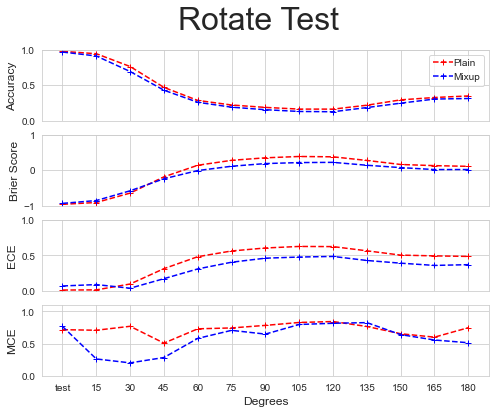

In [17]:
acc_values,bs_values,ece_values, mce_values = rotateTest(X_test,y_test,model,model_mixup)
plotRotateTest(acc_values,bs_values,ece_values,mce_values)